**Lab 4 – Data cleaning and feature engineering**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/phonchi/nsysu-math608/blob/master/static_files/presentations/04_Clean_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/phonchi/nsysu-math608/blob/master/static_files/presentations/04_Clean_feature_engineering.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# 🛠️ Setup

In [1]:
# @title Install packages
!pip install fancyimpute -qq
!pip install thefuzz -qq
!pip install category_encoders -qq
!pip install cleanlab[datalab] -qq

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour

In [146]:
# @title Import packages

import sys
# Scientific computing
import numpy as np
from numpy.random import multivariate_normal
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

# Modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

# Imputing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer # To use IterativeImputer, you need to explicitly import enable_iterative_imputer.
from sklearn.impute import IterativeImputer
from fancyimpute import SoftImpute

# helpful character encoding module
import chardet
from thefuzz import fuzz
from thefuzz import process

# Normalization
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from category_encoders import MEstimateEncoder

# Fix labels
import cleanlab
from cleanlab import Datalab
from cleanlab.classification import CleanLearning
from cleanlab.benchmarking import noise_generation

## For target encoding
from sklearn.preprocessing import KBinsDiscretizer

n_samples = 50_000

rng = np.random.RandomState(42)
y_target = rng.randn(n_samples)
noise = 0.5 * rng.randn(n_samples)
n_categories = 100

kbins = KBinsDiscretizer(
    n_bins=n_categories,
    encode="ordinal",
    strategy="uniform",
    random_state=rng,
    subsample=None,
)
X_informative = kbins.fit_transform((y_target + noise).reshape(-1, 1))

# Remove the linear relationship between y and the bin index by permuting the
# values of X_informative:
permuted_categories = rng.permutation(n_categories)
X_informative = permuted_categories[X_informative.astype(np.int32)]
X_shuffled = rng.permutation(X_informative)
X_near_unique_categories = rng.choice(
    int(0.9 * n_samples), size=n_samples, replace=True
).reshape(-1, 1)
X_target = pd.DataFrame(
    np.concatenate(
        [X_informative, X_shuffled, X_near_unique_categories],
        axis=1,
    ),
    columns=["informative", "shuffled", "near_unique"],
)

## Make synthetic dataset for cleanlab
SEED = 0

def make_data(
    means=[[3, 2], [7, 7], [0, 8], [0, 10]],
    covs=[
        [[5, -1.5], [-1.5, 1]],
        [[1, 0.5], [0.5, 4]],
        [[5, 1], [1, 5]],
        [[3, 1], [1, 1]],
    ],
    sizes=[100, 50, 50, 50],
    avg_trace=0.8,
    seed=SEED,  # set to None for non-reproducible randomness
):
    np.random.seed(seed=SEED)

    K = len(means)  # number of classes
    data = []
    labels = []
    test_data = []
    test_labels = []

    for idx in range(K):
        data.append(
            np.random.multivariate_normal(
                mean=means[idx], cov=covs[idx], size=sizes[idx]
            )
        )
        test_data.append(
            np.random.multivariate_normal(
                mean=means[idx], cov=covs[idx], size=sizes[idx]
            )
        )
        labels.append(np.array([idx for i in range(sizes[idx])]))
        test_labels.append(np.array([idx for i in range(sizes[idx])]))
    X_train = np.vstack(data)
    y_train = np.hstack(labels)
    X_test = np.vstack(test_data)
    y_test = np.hstack(test_labels)

    # Compute p(y=k) the prior distribution over true labels.
    py_true = np.bincount(y_train) / float(len(y_train))

    noise_matrix_true = noise_generation.generate_noise_matrix_from_trace(
        K,
        trace=avg_trace * K,
        py=py_true,
        valid_noise_matrix=True,
        seed=SEED,
    )

    # Generate our noisy labels using the noise_marix.
    s = noise_generation.generate_noisy_labels(y_train, noise_matrix_true)
    s_test = noise_generation.generate_noisy_labels(y_test, noise_matrix_true)
    ps = np.bincount(s) / float(len(s))  # Prior distribution over noisy labels

    return {
        "data": X_train,
        "true_labels": y_train,  # You never get to see these perfect labels.
        "labels": s,  # Instead, you have these labels, which have some errors.
        "test_data": X_test,
        "test_labels": y_test,  # Perfect labels used for "true" measure of model's performance during deployment.
        "noisy_test_labels": s_test,  # With IID train/test split, you'd have these labels, which also have some errors.
        "ps": ps,
        "py_true": py_true,
        "noise_matrix_true": noise_matrix_true,
        "class_names": ["purple", "blue", "seafoam green", "yellow"],
    }


# Display dataset visually using matplotlib
def plot_data(data, circles, title, alpha=1.0):
    plt.figure(figsize=(14, 5))
    plt.scatter(data[:, 0], data[:, 1], c=labels, s=60)
    for i in circles:
        plt.plot(
            data[i][0],
            data[i][1],
            "o",
            markerfacecolor="none",
            markeredgecolor="red",
            markersize=14,
            markeredgewidth=2.5,
            alpha=alpha
        )
    _ = plt.title(title, fontsize=25)


# 🔍 Exploratory Data Analysis

You can checkout some of useful EDA tools [ydata-profiling](https://github.com/ydataai/ydata-profiling), [dataprep](https://github.com/sfu-db/dataprep), [lux](https://github.com/lux-org/lux) or [dtale](https://github.com/man-group/dtale)

# 📘 Handling missing value

In this section, you'll learn why you've run into the data cleaning problems and, more importantly, how to fix them! Specifically, you’ll learn how to tackle some of the most common data cleaning problems so you can get to actually analyzing your data faster.

## Take a first look at the data

For demonstration, we'll use a dataset of events that occured in American Football games. You'll apply your new skills to a dataset of building permits issued in San Francisco. The dataset that we will use was made available by Kaggle. You can download the original dataset from https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016.

But you can also use Kaggle API. First, you need to create a Kaggle API key and download it to your local machine. Just navigate to the Kaggle website in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

<p align="center">
<img src="https://drive.google.com/uc?id=1Yo0bW4A59Se1EbE50JZMiWNueErB2eJa" alt="drawing" width="600"/>
</p>

In [3]:
# Upload the API’s key JSON file to your Colab
# session by running the following code in a notebook cell:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [4]:
# @title Downlaod
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

dataset = "maxhorowitz/nflplaybyplay2009to2016" #@param {type: "string"}

!kaggle datasets download -d {dataset}
!unzip -qq nflplaybyplay2009to2016

Dataset URL: https://www.kaggle.com/datasets/maxhorowitz/nflplaybyplay2009to2016
License(s): unknown
100% 274M/274M [00:15<00:00, 23.7MB/s]
100% 274M/274M [00:15<00:00, 18.8MB/s]


> In some dataset, when the first time you try to download the data, you may get a “403 Forbidden” error. That’s because you need to accept the terms associated with the dataset before you download it and click the "I Understand and Accept button". You only need to do this once.

In [5]:
# read in all our data
nfl_data = pd.read_csv("NFL Play by Play 2009-2017 (v4).csv")

# set seed for reproducibility
np.random.seed(0)

The first thing to do when you get a new dataset is take a look at some of it. This lets you see that it all read in correctly and gives an idea of what's going on with the data. In this case, let's see if there are any missing values, which will be reprsented with `NaN` or `None`.

In [14]:
# We can see a handful of missing data already!
nfl_data

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season
0,2009-09-10,2009091000,1,1,NaN,15:00,15,3600.0,0.0,TEN,...,NaN,0.485675,0.514325,0.546433,0.453567,0.485675,0.060758,NaN,NaN,2009
1,2009-09-10,2009091000,1,1,1.0,14:53,15,3593.0,7.0,PIT,...,1.146076,0.546433,0.453567,0.551088,0.448912,0.546433,0.004655,-0.032244,0.036899,2009
2,2009-09-10,2009091000,1,1,2.0,14:16,15,3556.0,37.0,PIT,...,NaN,0.551088,0.448912,0.510793,0.489207,0.551088,-0.040295,NaN,NaN,2009
3,2009-09-10,2009091000,1,1,3.0,13:35,14,3515.0,41.0,PIT,...,-5.031425,0.510793,0.489207,0.461217,0.538783,0.510793,-0.049576,0.106663,-0.156239,2009
4,2009-09-10,2009091000,1,1,4.0,13:27,14,3507.0,8.0,PIT,...,NaN,0.461217,0.538783,0.558929,0.441071,0.461217,0.097712,NaN,NaN,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407683,2017-12-31,2017123101,29,4,NaN,00:28,1,28.0,4.0,BAL,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,2017
407684,2017-12-31,2017123101,29,4,3.0,00:28,1,28.0,0.0,BAL,...,-0.397515,0.080409,0.919591,0.050478,0.949522,0.080409,-0.029931,-0.021795,-0.008136,2017
407685,2017-12-31,2017123101,29,4,4.0,00:24,1,24.0,4.0,BAL,...,2.457114,0.050478,0.949522,0.030881,0.969119,0.050478,-0.019597,-0.030603,0.011006,2017
407686,2017-12-31,2017123101,30,4,1.0,00:14,1,14.0,10.0,BAL,...,NaN,0.030881,0.969119,0.000000,1.000000,0.969119,0.030881,NaN,NaN,2017


In [7]:
nfl_data.shape

(407688, 102)

## How many missing data points do we have?

Ok, now we know that we do have some missing values. Let's see how many we have in each column.

In [12]:
# get the number of missing data points per column
missing_values_count = nfl_data.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count.sort_values(ascending=False)[0:10]

,0
DefTwoPoint,407664
BlockingPlayer,407571
TwoPointConv,407083
ChalReplayResult,404286
RecFumbPlayer,403315
RecFumbTeam,403315
Interceptor,403168
FieldGoalDistance,398740
FieldGoalResult,398629
ExPointResult,397578


In [13]:
# how many total missing values do we have?
total_cells = np.product(nfl_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

27.66722370547874


Almost a quarter of the cells in this dataset are empty! In the next step, we're going to take a closer look at some of the columns with missing values and try to figure out what might be going on with them.

📌 Looking at the number of missing values in the `nfl_data` dataframe, we notice that the column `TimesSecs` has missing values in it. By looking at [the documentation](https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016), we can see that this column has information on the number of seconds left in the game when the play was made. This means that these values are probably missing because **they were not recorded**, rather than because they don't exist. So, it would make sense for us to try and guess what they should be rather than just leaving them as NA's. On the other hand, there are other fields, like `PenalizedTeam` that also have lot of missing fields. In this case, though, the field is missing because if there was no penalty then it doesn't make sense to say *which* team was penalized. For this column, it would make more sense to either leave it empty or to add a third value like "neither" and use that to replace the NA's.

We'll cover some "quick and dirty" techniques that can help you with missing values but will probably also end up removing some useful information or adding some noise to your data.

## Drop missing values

If you're sure you want to drop rows with missing values, `Pandas` does have a handy function, `dropna()` to help you do this. Let's try it out on our NFL dataset!

In [19]:
# remove all the rows that contain a missing value results in empty dataset
# This is because every row in our dataset had at least one missing value.
# We might have better luck removing all the columns that have at least one missing value instead.
nfl_data.dropna()

,Date,GameID,Drive,qtr,down,time,TimeUnder,TimeSecs,PlayTimeDiff,SideofField,...,yacEPA,Home_WP_pre,Away_WP_pre,Home_WP_post,Away_WP_post,Win_Prob,WPA,airWPA,yacWPA,Season


In [20]:
# remove all columns with at least one missing value
columns_with_na_dropped = nfl_data.dropna(axis=1)
columns_with_na_dropped.head()

,Date,GameID,Drive,qtr,TimeUnder,ydstogo,ydsnet,PlayAttempted,Yards.Gained,sp,...,AwayTeam,Timeout_Indicator,posteam_timeouts_pre,HomeTimeouts_Remaining_Pre,AwayTimeouts_Remaining_Pre,HomeTimeouts_Remaining_Post,AwayTimeouts_Remaining_Post,ExPoint_Prob,TwoPoint_Prob,Season
0,2009-09-10,2009091000,1,1,15,0,0,1,39,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
1,2009-09-10,2009091000,1,1,15,10,5,1,5,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
2,2009-09-10,2009091000,1,1,15,5,2,1,-3,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
3,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009
4,2009-09-10,2009091000,1,1,14,8,2,1,0,0,...,TEN,0,3,3,3,3,3,0.0,0.0,2009


In [21]:
# just how much data did we lose?
print("Columns in original dataset: %d \n" % nfl_data.shape[1])
print("Columns with na's dropped: %d" % columns_with_na_dropped.shape[1])

Columns in original dataset: 102 

Columns with na's dropped: 37


Notice that this can drop a lot of data that you might want to keep, particularly in smaller datasets. What if you just want to drop rows or columns that contain several or even just all null values? You specify those setting in dropna with the `how` and `thresh` parameters.

By default, `how='any'`. You could alternatively specify `how='all'` so as to **drop only rows or columns that contain all null values**. The `thresh `parameter gives you finer-grained control: you set the number of non-null values that a row or column needs to have in order to be kept.

In [22]:
df1 = pd.DataFrame([[ 1, np.nan, 7],
           [ 2,  5,  8],
           [ np.nan, 6, 9]])
df1.loc[:,3] = np.nan
df1

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


In [23]:
# the `thresh` parameter specifies the minimum number of non-null values required in a row or column for it to be retained.
df1.dropna(thresh=3)

,0,1,2,3
1,2.0,5.0,8,NaN


Here, the first and last row have been dropped, because they contain only two non-null values.

## Filling in missing values automatically

Depending on your dataset, it can sometimes make more sense to fill null values with valid ones rather than drop them. `Pandas` provides `fillna()`, which returns a copy of the `Series` or `DataFrame` with the missing values replaced with one of your choosing.

In [24]:
# You can fill all of the null entries with a single value, such as -9999:
df1.fillna(-9999)

,0,1,2,3
0,1.0,-9999.0,7,-9999.0
1,2.0,5.0,8,-9999.0
2,-9999.0,6.0,9,-9999.0


We could also replace missing values with whatever value comes directly after/before it in the same column. (This makes a lot of sense for datasets where the observations have some sort of logical order to them.)

You can forward-fill null values, which is to use the last valid value to fill a null:

In [25]:
df1.ffill(axis=0)

,0,1,2,3
0,1.0,NaN,7,NaN
1,2.0,5.0,8,NaN
2,2.0,6.0,9,NaN


Backward-fill to propagate the next valid value backward to fill a null:

In [26]:
df1.bfill(axis=0)

,0,1,2,3
0,1.0,5.0,7,NaN
1,2.0,5.0,8,NaN
2,NaN,6.0,9,NaN


Notice that when a previous/next value is not available for forward/backward-filling, the null value remains.

## Imputation of missing value

### Univariate feature imputation

The [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) class from `sklearn` provides basic strategies for imputing missing values. Missing values can be imputed with a provided constant value, or using the statistics (mean, median or most frequent) of each column in which the missing values are located. This class also allows for different missing values encodings.

In [27]:
df2 = pd.DataFrame([[1, 2], [np.nan, 3], [7, 6]])
df2

,0,1
0,1.0,2
1,NaN,3
2,7.0,6


The following snippet demonstrates how to replace missing values, encoded as `np.nan`, using the mean value of the columns that contain the missing values:

In [28]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit_transform(df2)

array([[1., 2.],
       [4., 3.],
       [7., 6.]])

The `SimpleImputer` class also supports categorical data represented as string values or `Pandas` categoricals when using the `most_frequent` or `constant` strategy:

In [29]:
df2 = pd.DataFrame([["a", "x"],
           [np.nan, "y"],
           ["a", np.nan],
           ["b", "y"]],
          dtype="category")
df2

,0,1
0,a,x
1,NaN,y
2,a,NaN
3,b,y


In [30]:
imp = SimpleImputer(strategy="most_frequent")
print(imp.fit_transform(df2))

[['a' 'x']
 ['a' 'y']
 ['a' 'y']
 ['b' 'y']]


### Multivariate feature imputation

A more sophisticated approach is to use the [`IterativeImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html) class from `sklearn`, which models each feature with missing values as a function of other features, and uses that estimate for imputation.

In [31]:
imp = IterativeImputer(max_iter=10, random_state=0)
# the model learns that the second feature is double of the first
imp.fit_transform([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

array([[ 1.        ,  2.        ],
       [ 3.        ,  6.        ],
       [ 4.        ,  8.        ],
       [ 1.50004509,  3.        ],
       [ 7.        , 14.00004135]])

In [32]:
 # You can also use other regressor as well (default is BayesianRidge())
 est = ExtraTreesRegressor(n_estimators=50, random_state=42)
 imp = IterativeImputer(max_iter=10, random_state=0, estimator=est)
 imp.fit_transform([[1, 2], [3, 6], [4, 8], [np.nan, 3], [7, np.nan]])

array([[1.  , 2.  ],
       [3.  , 6.  ],
       [4.  , 8.  ],
       [1.44, 3.  ],
       [7.  , 8.  ]])

The [`KNNImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) class from `sklearn` provides imputation for filling in missing values using the k-Nearest Neighbors approach. By default, a euclidean distance metric that supports missing values, [`nan_euclidean_distances`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.nan_euclidean_distances.html), is used to find the nearest neighbors. Each missing feature is imputed using values from `n_neighbors` nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor.

The following snippet demonstrates how to replace missing values, encoded as `np.nan`, using the mean feature value of the two nearest neighbors of samples with missing values:

In [33]:
X = [[1, 2, np.nan], [3, 4, 3], [np.nan, 6, 5], [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2, weights="uniform")
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

if you wishes to apply matrix completion to your data, you can use functions from [`fancyimpute`](https://github.com/iskandr/fancyimpute)

In [34]:
SoftImpute().fit_transform(X)

[SoftImpute] Max Singular Value of X_init = 16.044670
[SoftImpute] Iter 1: observed MAE=0.129498 rank=3
[SoftImpute] Iter 2: observed MAE=0.129346 rank=3
[SoftImpute] Iter 3: observed MAE=0.129795 rank=3
[SoftImpute] Iter 4: observed MAE=0.131896 rank=3
[SoftImpute] Iter 5: observed MAE=0.134509 rank=3
[SoftImpute] Iter 6: observed MAE=0.137663 rank=3
[SoftImpute] Iter 7: observed MAE=0.141068 rank=3
[SoftImpute] Iter 8: observed MAE=0.143794 rank=3
[SoftImpute] Iter 9: observed MAE=0.145304 rank=3
[SoftImpute] Iter 10: observed MAE=0.145850 rank=3
[SoftImpute] Iter 11: observed MAE=0.145866 rank=3
[SoftImpute] Iter 12: observed MAE=0.145914 rank=3
[SoftImpute] Iter 13: observed MAE=0.146068 rank=3
[SoftImpute] Iter 14: observed MAE=0.146126 rank=2
[SoftImpute] Iter 15: observed MAE=0.146125 rank=2
[SoftImpute] Iter 16: observed MAE=0.146132 rank=2
[SoftImpute] Iter 17: observed MAE=0.146126 rank=2
[SoftImpute] Iter 18: observed MAE=0.146092 rank=2
[SoftImpute] Iter 19: observed MAE=0.

array([[1.        , 2.        , 1.29115131],
       [3.        , 4.        , 3.        ],
       [5.10495139, 6.        , 5.        ],
       [8.        , 8.        , 7.        ]])

For more information, please refer to https://github.com/iskandr/fancyimpute or https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute.

# 🔍 Other data cleaning problem

## Duplicate data entry

In addition to missing data, you will often encounter duplicated data in real-world datasets. Fortunately, `pandas` provides an easy means of detecting and removing duplicate entries.

You can easily spot duplicate values using the `duplicated()` method in `pandas`, which returns a Boolean mask indicating whether an entry in a `DataFrame` is a duplicate of an earlier one. Let's create another example `DataFrame` to see this in action.

In [35]:
df3 = pd.DataFrame({'letters': ['A','B'] * 2 + ['B'],
            'numbers': [1, 2, 1, 3, 3]})
df3

,letters,numbers
0,A,1
1,B,2
2,A,1
3,B,3
4,B,3


In [36]:
df3.duplicated()

,0
0,False
1,False
2,True
3,False
4,True


`drop_duplicates()` will simply returns a copy of the data for which all of the duplicated values are `False`:

In [37]:
df3.drop_duplicates()

,letters,numbers
0,A,1
1,B,2
3,B,3


Both `duplicated()` and `drop_duplicates()` default to consider all columns but you can specify that they examine only a subset of columns in your `DataFrame`:

In [38]:
df3.drop_duplicates(['letters'])

,letters,numbers
0,A,1
1,B,2


## Inconsistent data entry

We will use the dataset that is modified from https://www.kaggle.com/datasets/zusmani/pakistanintellectualcapitalcs.

In [39]:
# @title

dataset = "alexisbcook/pakistan-intellectual-capital" #@param {type: "string"}
!kaggle datasets download -d {dataset}
!unzip -qq pakistan-intellectual-capital.zip

Dataset URL: https://www.kaggle.com/datasets/alexisbcook/pakistan-intellectual-capital
License(s): unknown
  0% 0.00/47.8k [00:00<?, ?B/s]
100% 47.8k/47.8k [00:00<00:00, 1.40MB/s]


In [40]:
# read in all our data
professors = pd.read_csv("pakistan_intellectual_capital.csv", index_col=0)

# set seed for reproducibility
np.random.seed(0)

In [41]:
professors.head()

,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN
4,5,Dr. Waheed Noor,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,DBMS,NaN
5,6,Dr. Junaid Baber,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"Information processing, Multimedia mining",NaN
6,7,Dr. Maheen Bakhtyar,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,"NLP, Information Retrieval, Question Answering...",NaN
24,25,Samina Azim,Sardar Bahadur Khan Women's University,Computer Science,Balochistan,Lecturer,BS,Balochistan University of Information Technolo...,Pakistan,2005.0,VLSI Electronics DLD Database,NaN


Say we're interested in cleaning up the `Country` column to make sure there's no data entry inconsistencies in it. We could go through and check each row by hand, of course, and hand-correct inconsistencies when we find them. There's a more efficient way to do this, though!

In [42]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them and then take a closer look
countries.sort()
countries

array([' Germany', ' New Zealand', ' Sweden', ' USA', 'Australia',
       'Austria', 'Canada', 'China', 'Finland', 'France', 'Greece',
       'HongKong', 'Ireland', 'Italy', 'Japan', 'Macau', 'Malaysia',
       'Mauritius', 'Netherland', 'New Zealand', 'Norway', 'Pakistan',
       'Portugal', 'Russian Federation', 'Saudi Arabia', 'Scotland',
       'Singapore', 'South Korea', 'SouthKorea', 'Spain', 'Sweden',
       'Thailand', 'Turkey', 'UK', 'USA', 'USofA', 'Urbana', 'germany'],
      dtype=object)

Just looking at this, we can see some problems due to inconsistent data entry: ' Germany', and 'germany', for example, or ' New Zealand' (start wirh whitespace) and 'New Zealand'.

The first thing we are going to do is make everything lower case (we can change it back at the end if we like) and remove any white spaces at the beginning and end of cells. **Inconsistencies in capitalizations and trailing white spaces are very common in text data and you can fix a good 80% of your text data entry inconsistencies by doing this.**

In [43]:
# convert to lower case
professors['Country'] = professors['Country'].str.lower()
# remove trailing white spaces
professors['Country'] = professors['Country'].str.strip()

Note that `.str()` provide vectorized method for columns. See https://realpython.com/python-data-cleaning-numpy-pandas/#tidying-up-fields-in-the-data for more details.

### Use fuzzy matching to correct inconsistent data entry

Alright, let's take another look at the `Country` column and see if there's any more data cleaning we need to do

In [44]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea',
       'southkorea', 'spain', 'sweden', 'thailand', 'turkey', 'uk',
       'urbana', 'usa', 'usofa'], dtype=object)

It does look like there is another inconsistency: 'southkorea' and 'south korea' should be the same. We're going to use the [`thefuzz`](https://github.com/seatgeek/thefuzz) package to help identify which strings are closest to each other. This dataset is small enough that we could probably correct errors by hand, but that approach doesn't scale well. (Would you want to correct a thousand errors by hand? What about ten thousand? Automating things as early as possible is generally a good idea!)

`thefuzz` returns a ratio given two strings. The closer the ratio is to 100, the smaller the [edit distance](https://en.wikipedia.org/wiki/Edit_distance) between the two strings. Here, we're going to get the ten strings from our list of cities that have the closest distance to "south korea"

In [45]:
# get the top 10 closest matches to "south korea"
matches = process.extract("south korea", countries, limit=10)

# take a look at them
matches

[('south korea', 100),
 ('southkorea', 95),
 ('uk', 57),
 ('ireland', 54),
 ('norway', 54),
 ('usofa', 51),
 ('usa', 45),
 ('austria', 44),
 ('saudi arabia', 43),
 ('scotland', 42)]

We can see that two of the items in the cities are very close to "south korea": "south korea" and "southkorea". Let's replace all rows in our "Country" column that have a score > 90 with "south korea".

To do this, we are going to write a function.

In [46]:
# function to replace rows in the provided column of the provided dataframe
# that match the provided string above the provided ratio with the provided string
def replace_matches_in_column(df, column, string_to_match, min_ratio = 90):
    # get a list of unique strings
    strings = df[column].unique()

    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, strings, limit=10)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches
    df.loc[rows_with_matches, column] = string_to_match

    # let us know the function's done
    print("All done!")

Now that we have a function, we can put it to the test!

In [47]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"
replace_matches_in_column(df=professors, column='Country', string_to_match="south korea")

All done!


And now let's check the unique values in our "Country" column again and make sure we've tidied up "south korea" correctly.

In [48]:
# get all the unique values in the 'Country' column
countries = professors['Country'].unique()

# sort them alphabetically and then take a closer look
countries.sort()
countries

array(['australia', 'austria', 'canada', 'china', 'finland', 'france',
       'germany', 'greece', 'hongkong', 'ireland', 'italy', 'japan',
       'macau', 'malaysia', 'mauritius', 'netherland', 'new zealand',
       'norway', 'pakistan', 'portugal', 'russian federation',
       'saudi arabia', 'scotland', 'singapore', 'south korea', 'spain',
       'sweden', 'thailand', 'turkey', 'uk', 'urbana', 'usa', 'usofa'],
      dtype=object)

Now we only have "south korea" in our dataframe and we didn't have to change anything by hand!

## Character encoding

There are two main data types you'll encounter when working with text in `Python`. One is is the `string`, which is what text is by default.

In [49]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

The other data is the [bytes](https://docs.python.org/3/library/stdtypes.html#binary-sequence-types-bytes-bytearray-memoryview) data type, which is a sequence of integers. You can convert a `string` into `bytes` by specifying which encoding it's in:

In [50]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors="replace")

# check the type
type(after)

bytes

If you look at a `bytes` object, you'll see that it has a `b` in front of it, and then maybe some text after. **That's because bytes are printed out as if they were characters encoded in UTF-8**. Here you can see that our euro symbol  has been replaced with some mojibake that looks like "\xe2\x82\xac" when it's printed as if it were an UTF-8 string

In [51]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

When we convert our `bytes` back to a `string` with the correct encoding, we can see that our text is all there correctly, which is great! :)

In [52]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


However, when we try to use a different encoding to map our bytes into a string, we get an error. This is because the encoding we're trying to use doesn't know what to do with the `bytes` we're trying to pass it. You need to tell `Python` the encoding that the byte string is actually supposed to be in

In [53]:
# try to decode our bytes with the ascii encoding
print(after.decode("ascii"))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 25: ordinal not in range(128)

**The best time to convert non UTF-8 input into UTF-8 is when you read in files**, which we'll talk about next.

### Reading in files with encoding problems

Most files you'll encounter will probably be encoded with UTF-8. This is what `Python` expects by default, so most of the time you won't run into problems. However, sometimes you'll get an error like this:

In [54]:
dataset = "kemical/kickstarter-projects" #@param {type: "string"}

!kaggle datasets download -d {dataset}
!unzip -qq kickstarter-projects.zip

Dataset URL: https://www.kaggle.com/datasets/kemical/kickstarter-projects
License(s): CC-BY-NC-SA-4.0
 98% 36.0M/36.8M [00:03<00:00, 21.2MB/s]
100% 36.8M/36.8M [00:03<00:00, 12.6MB/s]


In [55]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x99 in position 7955: invalid start byte

Notice that we get the same `UnicodeDecodeError` we got when we tried to decode UTF-8 bytes! **This tells us that this file isn't actually UTF-8**. We don't know what encoding it actually *is* though. One way to figure it out is to try and test a bunch of different character encodings and see if any of them work. A better way, though, is to use the [`chardet`](https://github.com/chardet/chardet) module to try and automatically guess what the right encoding is. It's not 100% guaranteed to be right, but it's usually faster than just trying to guess.

We are going to just look at the first ten thousand bytes of this file. This is usually enough for a good guess about what the encoding is and is much faster than trying to look at the whole file. (Especially with a  large file this can be very slow.)

In [56]:
# look at the first ten thousand bytes to guess the character encoding
with open("ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


So chardet is 73%  confidence that the right encoding is "Windows-1252". Let's see if that's correct:

In [57]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv("ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


Yep, looks like `chardet` was right! The file reads in with no problem (although we do get a warning about datatypes) and when we look at the first few rows it seems to be fine.

What if the encoding `chardet` guesses isn't right? Since `chardet` is basically just a fancy guesser, sometimes it will guess the wrong encoding. **One thing you can try is looking at more or less of the file and seeing if you get a different result and then try that.**

### Saving your files with UTF-8 encoding


Finally, once you've gone through all the trouble of getting your file into UTF-8, you'll probably want to keep it that way. The easiest way to do that is to save your files with UTF-8 encoding. The good news is, since UTF-8 is the standard encoding in `Python`, when you save a file it will be saved as UTF-8 by default:

In [58]:
# save our file (will be saved as UTF-8 by default!)
kickstarter_2016.to_csv("ks-projects-201612-utf8.csv")

In [59]:
# try to read in a file not in UTF-8
kickstarter_2016 = pd.read_csv("ks-projects-201612-utf8.csv")
kickstarter_2016.head()

,Unnamed: 0,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,NaN,NaN,NaN,NaN
1,1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,NaN,NaN,NaN,NaN
2,2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,NaN,NaN,NaN,NaN
3,3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,NaN,NaN,NaN,NaN
4,4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,NaN,NaN,NaN,NaN


# 📘 Scaling and normalization

## Standardization

By scaling your variables, you can help compare different variables on equal footing. The [`preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) module from `sklearn` provides the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) utility class, which is a quick and easy way to perform the following operation on an array-like dataset.

In [60]:
if "google.colab" in sys.modules:
    pass
else:
    !pip install gdown

In [61]:
!gdown --fuzzy https://drive.google.com/file/d/1HEcKRMe_bpgmQH3vFlRZVDF_gAzYGETE/view?usp=sharing # use --fuzzy so that it directly accept link from google drive
!gdown --fuzzy https://drive.google.com/file/d/1GQ1z0-aRPCzMQTcc1ckDgwkiF-GNP_t3/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1HEcKRMe_bpgmQH3vFlRZVDF_gAzYGETE
To: /content/train_preprocessed.csv
100% 1.14M/1.14M [00:00<00:00, 95.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GQ1z0-aRPCzMQTcc1ckDgwkiF-GNP_t3
To: /content/test_preprocessed.csv
100% 1.12M/1.12M [00:00<00:00, 78.4MB/s]


In [62]:
train = pd.read_csv('train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('test_preprocessed.csv')
train_x_saved = train_x.copy()
test_x_saved = test_x.copy()

def load_data():
    train_x, test_x = train_x_saved.copy(), test_x_saved.copy()
    return train_x, test_x

train

,age,sex,height,weight,product,amount,medical_info_a1,medical_info_a2,medical_info_a3,medical_info_b1,...,medical_keyword_6,medical_keyword_7,medical_keyword_8,medical_keyword_9,medical_keyword_10,year,month,day,yearmonth,target
0,50,1,166.445608,65.016732,9,7000000,134,202,1,11,...,1,0,1,0,0,2015,2,3,24182,0
1,68,0,164.334615,56.544217,0,7000000,438,263,3,14,...,0,1,1,0,0,2015,5,9,24185,0
2,77,1,167.462917,54.242267,2,6000000,313,325,1,18,...,1,0,1,0,0,2016,2,13,24194,1
3,17,1,177.097725,71.147762,3,8000000,342,213,2,11,...,0,0,1,0,0,2015,7,6,24187,0
4,62,0,158.165788,65.240697,1,9000000,327,102,0,14,...,0,1,1,1,0,2016,9,17,24201,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,1,182.729800,73.393777,1,2000000,189,232,7,17,...,0,0,1,1,0,2015,10,21,24190,0
9996,33,0,167.701136,75.006529,8,9000,426,202,3,19,...,0,0,1,1,0,2015,5,28,24185,0
9997,44,0,145.609998,47.739397,8,1000,370,274,1,11,...,0,0,1,0,1,2016,2,29,24194,0
9998,34,0,165.796017,57.567695,6,5000,291,105,1,13,...,1,1,1,1,0,2016,2,27,24194,0


In [63]:
num_cols = ['age', 'height', 'weight', 'amount',
       'medical_info_a1', 'medical_info_a2', 'medical_info_a3', 'medical_info_b1'] # some numerical columns

In [64]:
train_x, test_x = load_data()
scaler = StandardScaler()
scaler.fit(train_x[num_cols])

StandardScaler()

📌 Notice that **you should apply the same transfrom** on both training and testing dataset.

In [65]:
train_x[num_cols] = scaler.transform(train_x[num_cols])
test_x[num_cols] = scaler.transform(test_x[num_cols])

In [66]:
scaler.mean_,  scaler.scale_

(array([4.20265000e+01, 1.65892951e+02, 6.08570495e+01, 3.84084370e+06,
        2.99101200e+02, 2.49454700e+02, 1.98780000e+00, 1.44192000e+01]),
 array([2.16749209e+01, 9.40817216e+00, 1.07177883e+01, 3.45926743e+06,
        1.04491031e+02, 1.03710381e+02, 1.41733947e+00, 2.87131875e+00]))

Scaled data has zero mean and unit variance:

In [67]:
train_x[num_cols].mean(axis=0)

,0
age,6.679102e-17
height,-2.836842e-15
weight,-2.337686e-16
amount,-3.588241e-17
medical_info_a1,-5.684342e-17
medical_info_a2,-2.344791e-17
medical_info_a3,1.563194e-17
medical_info_b1,-3.410605e-17


In [68]:
train_x[num_cols].std(axis=0)

,0
age,1.00005
height,1.00005
weight,1.00005
amount,1.00005
medical_info_a1,1.00005
medical_info_a2,1.00005
medical_info_a3,1.00005
medical_info_b1,1.00005


> Note that it is possible to disable either centering or scaling by either passing `with_mean=False` or `with_std=False` to the constructor of `StandardScaler`.

## Scaling

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one.

In [69]:
scaler = MinMaxScaler()
scaler.fit(train_x[num_cols])

MinMaxScaler()

In [70]:
train_x[num_cols] = scaler.transform(train_x[num_cols])
test_x[num_cols] = scaler.transform(test_x[num_cols])

In [71]:
train_x[num_cols].describe()

,age,height,weight,amount,medical_info_a1,medical_info_a2,medical_info_a3,medical_info_b1
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.500358,0.524152,0.380388,0.384023,0.470184,0.487333,0.220867,0.491022
std,0.292919,0.143889,0.125162,0.345979,0.136063,0.130789,0.157490,0.319051
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243243,0.427145,0.292879,0.000800,0.376302,0.399748,0.111111,0.222222
50%,0.513514,0.527079,0.376458,0.299930,0.470703,0.488020,0.222222,0.444444
75%,0.756757,0.624006,0.461614,0.699970,0.563802,0.576293,0.333333,0.777778
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


> Note that you can scale to any range by specifying `feature_range=(min, max)`.

## Logarithm transform and binning

In [72]:
x = np.array([1.0, 10.0, 100.0, 1000.0, 10000.0])

In [73]:
np.log(x)

array([0.        , 2.30258509, 4.60517019, 6.90775528, 9.21034037])

In [74]:
# If your data contains zero value, try to plus one first
np.log1p(x)

array([0.69314718, 2.39789527, 4.61512052, 6.90875478, 9.21044037])

Binning allows you to transform numerical variable to categorical variable

In [76]:
x = [1, 7, 5, 4, 6, 3]

In [77]:
bin_edges = [-float('inf'), 3.0, 5.0, float('inf')]
binned = pd.cut(x, bin_edges, labels=False, retbins=True)
print(binned)

(array([0, 2, 1, 1, 2, 0]), array([-inf,   3.,   5.,  inf]))


## [Power transfrom](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.power_transform.html)

In [78]:
train_x, test_x = load_data()

Box-cox transform only works for postive data

In [79]:
pos_cols = [c for c in num_cols if (train_x[c] > 0.0).all() and (test_x[c] > 0.0).all()] # List comprehension which is similar to set-builder notation

In [80]:
pt = PowerTransformer(method='box-cox')
pt.fit(train_x[pos_cols])

PowerTransformer(method='box-cox')

In [81]:
train_x[pos_cols] = pt.transform(train_x[pos_cols])
test_x[pos_cols] = pt.transform(test_x[pos_cols])

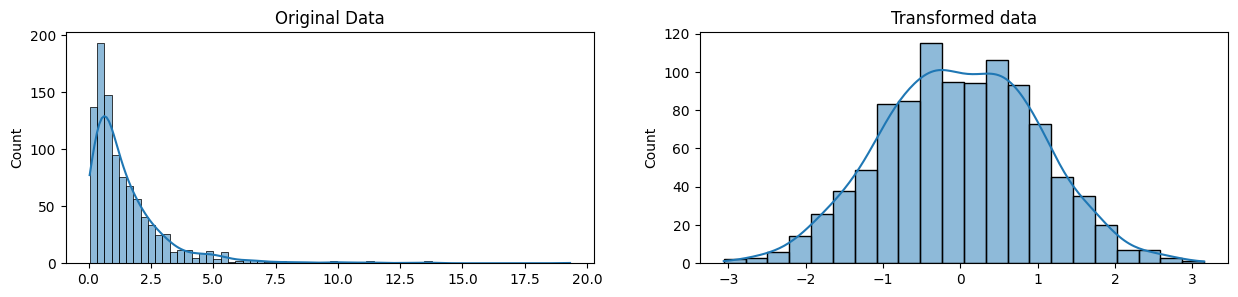

In [82]:
rng = np.random.RandomState(304)
original_data = rng.lognormal(size=(1000,1))
pt = PowerTransformer(method='box-cox')
transformed_data = pt.fit_transform(original_data)

fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data");

In [83]:
train_x, test_x = load_data()

In [84]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(train_x[num_cols])

PowerTransformer()

In [85]:
train_x[num_cols] = pt.transform(train_x[num_cols])
test_x[num_cols] = pt.transform(test_x[num_cols])

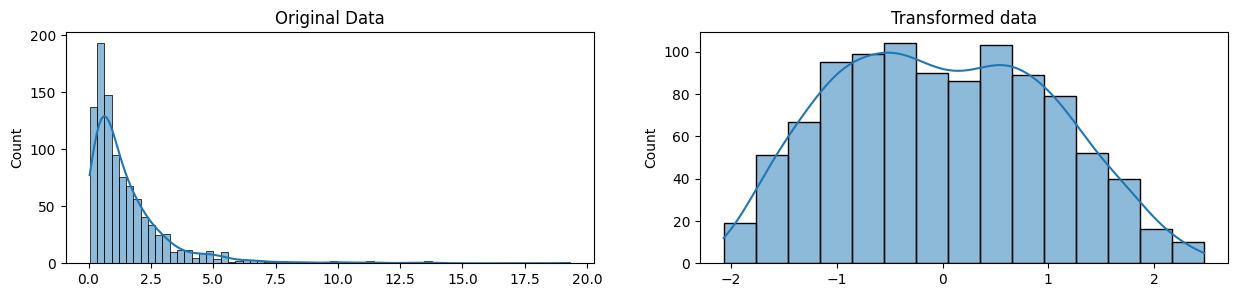

In [86]:
rng = np.random.RandomState(304)
original_data = rng.lognormal(size=(1000,1))
pt = PowerTransformer(method='yeo-johnson')
transformed_data = pt.fit_transform(original_data)

fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data");

## Quantile transfrom

In [87]:
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
transformer.fit(train_x[num_cols])

QuantileTransformer(n_quantiles=100, output_distribution='normal',
                    random_state=0)

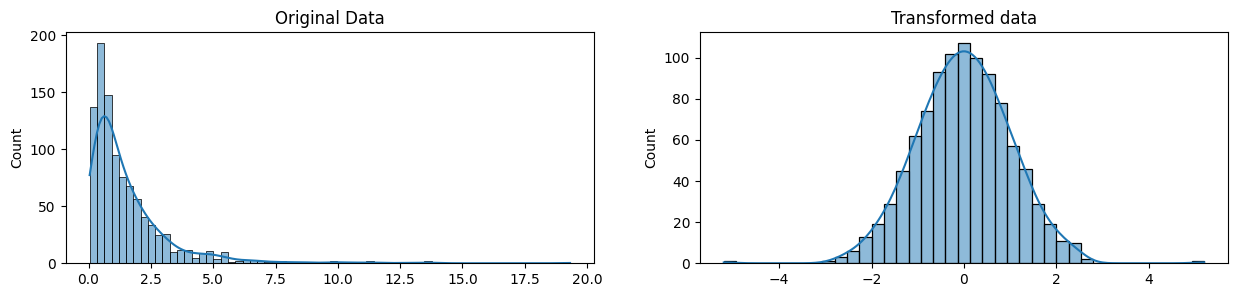

In [88]:
rng = np.random.RandomState(304)
original_data = rng.lognormal(size=(1000,1))
transformer = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
transformed_data = transformer.fit_transform(original_data)

fig, ax=plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(original_data, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Original Data")
sns.histplot(transformed_data, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Transformed data")
plt.show()

# 📘 Encoding

## One-hot encoding

One possibility to convert categorical features to features that can be used with `scikit-learn` estimators is to use a one-of-K, also known as one-hot or dummy encoding. This type of encoding can be obtained with the [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), which transforms each categorical feature with `n_categories` possible values into `n_categories` binary features, with one of them 1, and all others 0.

In [89]:
enc = OneHotEncoder(drop=None, handle_unknown='ignore') # In practice, you may want to drop one feature

📌 Note `handle_unknown` specifies the way unknown categories are handled during transform.
- "error" : Raise an error if an unknown category is present during transform.
- "ignore" : When an unknown category is encountered during transform, the resulting one-hot encoded columns for this feature will be all zeros. In the inverse transform, an unknown category will be denoted as `None`.

In [90]:
X = pd.DataFrame(np.array([['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox'], ['female', 'from Europe', 'uses Chrome']]), columns=['gender', 'locations', 'browsers'])
X.head()

,gender,locations,browsers
0,male,from US,uses Safari
1,female,from Europe,uses Firefox
2,female,from Europe,uses Chrome


In [91]:
onehot_encoded = enc.fit_transform(X).toarray()
pd.DataFrame(onehot_encoded, columns=enc.get_feature_names_out())

,gender_female,gender_male,locations_from Europe,locations_from US,browsers_uses Chrome,browsers_uses Firefox,browsers_uses Safari
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0


When an unknown category is encountered during `transform()`, the resulting one-hot encoded columns for this feature will be all zeros:

In [92]:
X_test = pd.DataFrame(np.array([['male', 'from US', 'uses Firefox'], ['female', 'from Europe', 'uses IE']]), columns=['gender', 'locations', 'browsers'])
X_test

,gender,locations,browsers
0,male,from US,uses Firefox
1,female,from Europe,uses IE


In [93]:
onehot_encoded = enc.transform(X_test).toarray()
pd.DataFrame(onehot_encoded, columns=enc.get_feature_names_out())

,gender_female,gender_male,locations_from Europe,locations_from US,browsers_uses Chrome,browsers_uses Firefox,browsers_uses Safari
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0


## [Ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html)

In [94]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1)

In [95]:
X = pd.DataFrame(np.array([['male', 'from US', 'uses Safari'], ['female', 'from Europe', 'uses Firefox'], ['female', 'from Europe', 'uses Chrome']]), columns=['gender', 'locations', 'browsers'])
X.head()

,gender,locations,browsers
0,male,from US,uses Safari
1,female,from Europe,uses Firefox
2,female,from Europe,uses Chrome


In [96]:
ordinal_encoded = enc.fit_transform(X)
pd.DataFrame(ordinal_encoded, columns=enc.get_feature_names_out())

,gender,locations,browsers
0,1.0,1.0,2.0
1,0.0,0.0,1.0
2,0.0,0.0,0.0


In [97]:
X_test = pd.DataFrame(np.array([['male', 'from US', 'uses Firefox'], ['female', 'from Europe', 'uses IE']]), columns=['gender', 'locations', 'browsers'])
X_test

,gender,locations,browsers
0,male,from US,uses Firefox
1,female,from Europe,uses IE


In [98]:
ordinal_encoded = enc.transform(X_test)
pd.DataFrame(ordinal_encoded, columns=enc.get_feature_names_out())

,gender,locations,browsers
0,1.0,1.0,1.0
1,0.0,0.0,-1.0


## Target encoding

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, random_state=0)

In [156]:
ridge = Ridge(alpha=1e-6, solver="lsqr", fit_intercept=False)
model_with_cf = make_pipeline(TargetEncoder(random_state=0, cv=5, smooth='auto'), ridge)
model_with_cf.fit(X_train, y_train)
print("Model with CF on train set: ", model_with_cf.score(X_train, y_train))
print("Model with CF on test set: ", model_with_cf.score(X_test, y_test))

Model with CF on train set:  0.8000184677460286
Model with CF on test set:  0.7927845601690948


In [157]:
target_encoder = TargetEncoder(random_state=0)
target_encoder.fit(X_train, y_train)
X_train_no_cf_encoding = target_encoder.transform(X_train)
X_test_no_cf_encoding = target_encoder.transform(X_test)

model_no_cf = ridge.fit(X_train_no_cf_encoding, y_train)

In [158]:
print(
    "Model without CF on training set: ",
    model_no_cf.score(X_train_no_cf_encoding, y_train),
)
print(
    "Model without CF on test set: ",
    model_no_cf.score(
        X_test_no_cf_encoding,
        y_test,
    ),
)

Model without CF on training set:  0.858486250088675
Model without CF on test set:  0.6338211367110066


📌 This example demonstrates the importance of `TargetEncoder`’s internal cross fitting. It is important to use `TargetEncoder.fit_transform()` to encode training data before passing it to a machine learning model. While `TargetEncoder.fit_transform()` uses an internal cross fitting scheme to learn encodings for the training set, `TargetEncoder.transform()` itself does not! It uses the complete training set to learn encodings and to transform the categorical features. The ridge model overfits in this case!

### Use `category_encoders`

The [*MovieLens1M*](https://www.kaggle.com/datasets/odedgolden/movielens-1m-dataset) dataset contains one-million movie ratings by users of the MovieLens website, with features describing each user and movie. This hidden cell sets everything up:

In [99]:
# @title

dataset = "odedgolden/movielens-1m-dataset" #@param {type: "string"}

!kaggle datasets download -d {dataset}
zip_name = dataset.split('/')[1]
!unzip -qq {zip_name}.zip

ratings = pd.read_csv('ratings.dat',sep='::', header=None, names=["UserID", "MovieID", "Rating", "Timestamp"])
users = pd.read_csv('users.dat',sep='::', header=None, names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])
df = pd.merge(left=ratings, right=users, how='inner', on='UserID')
df = df.astype(np.uint8, errors='ignore') # reduce memory footprint

Dataset URL: https://www.kaggle.com/datasets/odedgolden/movielens-1m-dataset
License(s): unknown
 69% 4.00M/5.83M [00:00<00:00, 6.04MB/s]
100% 5.83M/5.83M [00:01<00:00, 6.03MB/s]


In [100]:
print("Number of Unique Zipcodes: {}".format(df["Zip-code"].nunique()))

Number of Unique Zipcodes: 3439


In [101]:
df

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code
0,1,169,5,88,F,1,10,48067
1,1,149,3,157,F,1,10,48067
2,1,146,3,16,F,1,10,48067
3,1,80,4,115,F,1,10,48067
4,1,51,5,99,F,1,10,48067
...,...,...,...,...,...,...,...,...
1000204,152,67,1,253,M,25,6,11106
1000205,152,70,5,119,M,25,6,11106
1000206,152,50,5,234,M,25,6,11106
1000207,152,72,4,128,M,25,6,11106


With over 3000 categories, the `Zipcode` feature makes a good candidate for target encoding, and the size of this dataset (over one-million rows) means we can spare some data to create the encoding.

We'll start by creating a 25% split to train the target encoder.

In [102]:
X = df.copy()
y = X.pop('Rating') # Target

X_encode = X.sample(frac=0.25)
y_encode = y[X_encode.index]
X_pretrain = X.drop(X_encode.index)
y_train = y[X_pretrain.index]

The [`category_encoders`](https://github.com/scikit-learn-contrib/category_encoders) package in `scikit-learn-contrib` implements an [`MEstimateEncoder`](https://contrib.scikit-learn.org/category_encoders/mestimate.html), which we'll use to encode our `Zipcode` feature.

In [103]:
# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["Zip-code"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_encode, y_encode)

# Encode the Zipcode column to create the final training data
X_train = encoder.transform(X_pretrain)

Let's compare the encoded values to the target to see how informative our encoding might be.

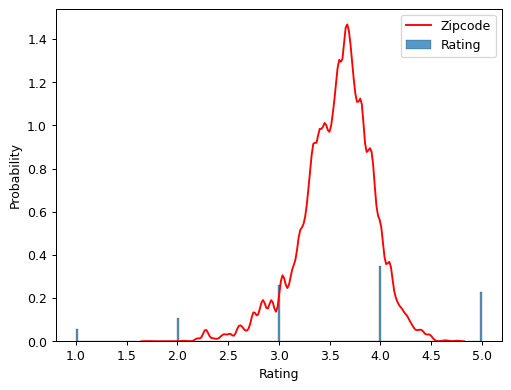

In [104]:
plt.figure(dpi=90)
ax = sns.histplot(y, kde=False, stat='probability')
ax = sns.kdeplot(X_train["Zip-code"], color='r', ax=ax)
ax.set_xlabel("Rating")
ax.legend(labels=['Zipcode', 'Rating']);

The distribution of the encoded `Zipcode` feature roughly follows the distribution of the actual ratings, meaning that movie-watchers differed enough in their ratings from zipcode to zipcode that our target encoding was able to capture useful information.

If you would like to use KFold encoding, take a look at http://contrib.scikit-learn.org/category_encoders/wrapper.html#category_encoders.wrapper.NestedCVWrapper

# 📘 Feature Engineering

We'll see how adding a few synthetic features to a dataset can improve the predictive performance of a random forest model.

The [*Concrete*](https://www.kaggle.com/sinamhd9/concrete-comprehensive-strength) dataset contains a variety of concrete formulations and the resulting product's *compressive strength*, which is a measure of how much load that kind of concrete can bear. The task for this dataset is to predict a concrete's compressive strength given its formulation.

In [151]:
# @title

dataset = "sinamhd9/concrete-comprehensive-strength" #@param {type: "string"}

!kaggle datasets download -d {dataset}
zip_name = dataset.split('/')[1]
!unzip -qq {zip_name}.zip

Dataset URL: https://www.kaggle.com/datasets/sinamhd9/concrete-comprehensive-strength
License(s): copyright-authors
  0% 0.00/32.9k [00:00<?, ?B/s]
100% 32.9k/32.9k [00:00<00:00, 3.06MB/s]


In [152]:
df = pd.read_excel("Concrete_Data.xls")
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


You can see here the various ingredients going into each variety of concrete. We'll see in a moment how adding some additional synthetic features derived from these can help a model to learn important relationships among them. We'll first establish a baseline by training the model on the un-augmented dataset. This will help us determine whether our new features are actually useful.

> Establishing baselines like this is good practice at the start of the feature engineering process. A baseline score can help you decide whether your new features are worth keeping, or whether you should discard them and possibly try something else.

In [153]:
df.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [154]:
X = df.copy()
y = X.pop(df.columns[-1])

# Train and score baseline model
baseline = RandomForestRegressor(criterion="absolute_error", random_state=0)
baseline_score = cross_val_score(
    baseline, X, y, cv=5, scoring="neg_mean_absolute_error"
)
baseline_score = -1 * baseline_score.mean()

print(f"MAE Baseline Score: {baseline_score:.4}")

MAE Baseline Score: 8.397


If you ever cook at home, you might know that the ***ratio*** of ingredients in a recipe is usually a better predictor of how the recipe turns out than their absolute amounts. We might reason then that ratios of the features above would be a good predictor of `CompressiveStrength`. The cell below adds three new ratio features to the dataset.

In [159]:
X = df.copy()
y = X.pop(df.columns[-1])

# Create synthetic features
X["FCRatio"] = X[df.columns[-2]] / X[df.columns[-3]]
X["AggCmtRatio"] = (X[df.columns[-3]] + X[df.columns[-2]]) / X[df.columns[0]]
X["WtrCmtRatio"] = X[df.columns[3]] / X[df.columns[0]]

# Train and score model on dataset with additional ratio features
model = RandomForestRegressor(criterion="absolute_error", random_state=0)
score = cross_val_score(
    model, X, y, cv=5, scoring="neg_mean_absolute_error"
)
score = -1 * score.mean()

print(f"MAE Score with Ratio Features: {score:.4}")

MAE Score with Ratio Features: 7.732


And sure enough, performance improved! This is evidence that these new ratio features exposed important information to the model that it wasn't detecting before.

## Mathematical Transforms

We'll use four datasets that having a range of feature types: [*US Traffic Accidents*](https://www.kaggle.com/sobhanmoosavi/us-accidents), [*1985 Automobiles*](https://www.kaggle.com/toramky/automobile-dataset), and [*Customer Lifetime Value*](https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data). The following hidden cell loads them up.

In [163]:
!gdown --fuzzy https://drive.google.com/file/d/12OQsuMwsR4wVCQiHfo4xKd3FLiH_jWCX/view?usp=sharing

dataset2 = "toramky/automobile-dataset" #@param {type: "string"}

!kaggle datasets download -d {dataset2}
zip_name = dataset2.split('/')[1]
!unzip -qq {zip_name}.zip

dataset3 = "pankajjsh06/ibm-watson-marketing-customer-value-data" #@param {type: "string"}

!kaggle datasets download -d {dataset3}
zip_name = dataset3.split('/')[1]
!unzip -qq {zip_name}.zip

Downloading...
From: https://drive.google.com/uc?id=12OQsuMwsR4wVCQiHfo4xKd3FLiH_jWCX
To: /content/accidents.csv
100% 21.4M/21.4M [00:00<00:00, 29.9MB/s]
Dataset URL: https://www.kaggle.com/datasets/toramky/automobile-dataset
License(s): unknown
automobile-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Automobile_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset URL: https://www.kaggle.com/datasets/pankajjsh06/ibm-watson-marketing-customer-value-data
License(s): unknown
ibm-watson-marketing-customer-value-data.zip: Skipping, found more recently modified local copy (use --force to force download)
replace WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [164]:
accidents = pd.read_csv("accidents.csv")
autos = pd.read_csv("Automobile_data.csv")
concrete = pd.read_excel("Concrete_Data.xls")
customer = pd.read_csv("WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv")

In [165]:
autos.replace("?", np.nan, inplace = True)
avg_bore=autos['bore'].astype('float').mean(axis=0)
autos["bore"].replace(np.nan, avg_bore, inplace=True)
avg_stroke = autos["stroke"].astype("float").mean(axis=0)
autos["stroke"].replace(np.nan, avg_stroke, inplace=True)

Relationships among numerical features are often expressed through mathematical formulas, which you'll frequently come across as part of your domain research. In `Pandas`, you can apply arithmetic operations to columns just as if they were ordinary numbers.

In the *Automobile* dataset are features describing a car's engine. Research yields a variety of formulas for creating potentially useful new features. The "stroke ratio", for instance, is a measure of how efficient an engine is versus how performant:

In [166]:
autos[["bore", "stroke"]] = autos[["bore", "stroke"]].astype("float")
autos["stroke_ratio"] = autos.stroke/ autos.bore
autos[["stroke", "bore", "stroke_ratio"]].head()

,stroke,bore,stroke_ratio
0,2.68,3.47,0.772334
1,2.68,3.47,0.772334
2,3.47,2.68,1.294776
3,3.40,3.19,1.065831
4,3.40,3.19,1.065831


Data visualization can suggest transformations, often a "reshaping" of a feature through powers or logarithms. The distribution of `WindSpeed` in *US Accidents* is highly skewed, for instance. In this case the logarithm is effective at normalizing it:

In [167]:
accidents.columns

Index(['Severity', 'StartTime', 'EndTime', 'StartLat', 'StartLng', 'Distance',
       'Street', 'City', 'State', 'Zipcode', 'Temperature', 'Humidity',
       'Pressure', 'Visibility', 'WindSpeed', 'Precipitation',
       'WeatherCondition', 'Amenity', 'Bump', 'Crossing', 'GiveWay',
       'Junction', 'NoExit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'TrafficCalming', 'TrafficSignal'],
      dtype='object')

In [168]:
accidents["WindSpeed"].describe()

,WindSpeed
count,100000.000000
mean,7.302313
std,6.208804
min,0.000000
25%,3.500000
50%,6.900000
75%,10.400000
max,822.800000


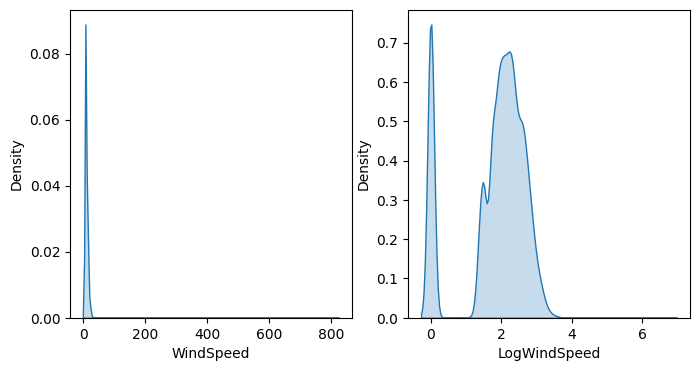

In [169]:
# If the feature has 0.0 values, use np.log1p (log(1+x)) instead of np.log
accidents["LogWindSpeed"] = accidents["WindSpeed"].apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(accidents["WindSpeed"], fill=True, ax=axs[0])
sns.kdeplot(accidents.LogWindSpeed, fill=True, ax=axs[1]);

## Counts

Features describing the presence or absence of something often come in sets, the set of risk factors for a disease, say. You can aggregate such features by creating a **count**. These features will be *binary* (`1` for Present, `0` for Absent) or *boolean* (`True` or `False`). In `Python`, booleans can be added up just as if they were integers.

In *Traffic Accidents* are several features indicating whether some roadway object was near the accident. This will create a count of the total number of roadway features nearby using the `sum()` method:

In [170]:
roadway_features = ["Amenity", "Bump", "Crossing", "GiveWay",
    "Junction", "NoExit", "Railway", "Roundabout", "Station", "Stop",
    "TrafficCalming", "TrafficSignal"]
accidents["RoadwayFeatures"] = accidents[roadway_features].sum(axis=1)

accidents[roadway_features + ["RoadwayFeatures"]].head(10)

,Amenity,Bump,Crossing,GiveWay,Junction,NoExit,Railway,Roundabout,Station,Stop,TrafficCalming,TrafficSignal,RoadwayFeatures
0,False,False,False,False,False,False,False,False,False,False,False,False,0
1,False,False,False,False,False,False,False,False,False,False,False,False,0
2,False,False,False,False,False,False,False,False,False,False,False,False,0
3,False,False,False,False,False,False,False,False,False,False,False,False,0
4,False,False,False,False,False,False,False,False,False,False,False,False,0
5,False,False,False,False,True,False,False,False,False,False,False,False,1
6,False,False,False,False,False,False,False,False,False,False,False,False,0
7,False,False,True,False,False,False,False,False,False,False,False,True,2
8,False,False,True,False,False,False,False,False,False,False,False,True,2
9,False,False,False,False,False,False,False,False,False,False,False,False,0


## Group Transforms

Finally we have **Group transforms**, which aggregate information across multiple rows grouped by some category. With a group transform you can create features like: "the average income of a person's state of residence," or "the proportion of movies released on a weekday, by genre." If you had discovered a category interaction, a group transform over that categry could be something good to investigate.

Using an aggregation function, a group transform combines two features: a categorical feature that provides the grouping and another feature whose values you wish to aggregate. For an "average income by state", you would choose `State` for the grouping feature, `mean()` for the aggregation function, and `Income` for the aggregated feature. To compute this in `Pandas`, we use the `groupby()` and `transform()` methods:

In [171]:
customer["AverageIncome"] = (
    customer.groupby("State")  # for each state
    ["Income"]          # select the income
    .transform("mean")      # and compute its mean
)

customer[["State", "Income", "AverageIncome"]]

,State,Income,AverageIncome
0,Washington,56274,38122.733083
1,Arizona,0,37405.402231
2,Nevada,48767,38369.605442
3,California,0,37558.946667
4,Washington,43836,38122.733083
...,...,...,...
9129,California,71941,37558.946667
9130,California,21604,37558.946667
9131,California,0,37558.946667
9132,California,21941,37558.946667


The `mean()` function is a built-in `dataframe` method, which means we can pass it as a string to `transform()`. Other handy methods include `max()`, `min()`, `median()`, `var()`, `std()`, and `count()`. Here's how you could calculate the frequency with which each state occurs in the dataset:


In [172]:
customer["StateFreq"] = (
    customer.groupby("State")
    ["State"]
    .transform("count")
    / customer.State.count()
)

customer[["State", "StateFreq"]]

,State,StateFreq
0,Washington,0.087366
1,Arizona,0.186446
2,Nevada,0.096562
3,California,0.344865
4,Washington,0.087366
...,...,...
9129,California,0.344865
9130,California,0.344865
9131,California,0.344865
9132,California,0.344865


# 🔍 Automatic feature engineering by [`featuretools`](https://github.com/alteryx/featuretools)

Check out https://github.com/alteryx/predict-appointment-noshow for more information!

# 📘 Data-centric AI with `CleanLab`

`cleanlab` automatically finds and fixes errors in any ML dataset. This data-centric AI package facilitates machine learning with messy, real-world data by providing clean labels during training.

In [173]:
data_dict = make_data()
for key, val in data_dict.items():  # Map data_dict to variables in namespace
    print(key)
    exec(key + "=val")

data
true_labels
labels
test_data
test_labels
noisy_test_labels
ps
py_true
noise_matrix_true
class_names


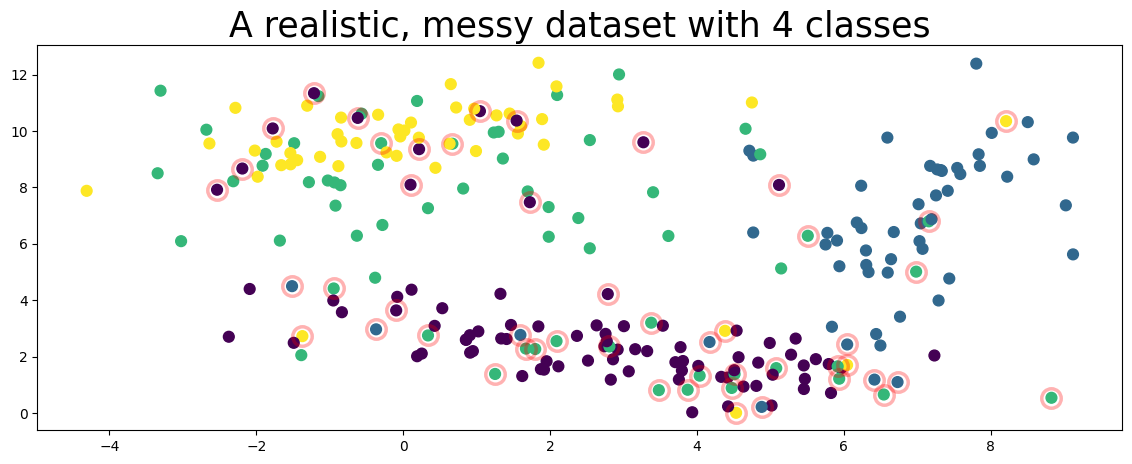

In [174]:
true_errors = np.where(true_labels != labels)[0]
plot_data(data, circles=true_errors, title="A realistic, messy dataset with 4 classes", alpha=0.3)

The figure above represents a toy dataset we’ll use to demonstrate various `cleanlab` functionality. In this data, the features `X` are 2-dimensional and examples are colored according to their given label above. The given label happens to be incorrect for some of the examples (circled in red) in this dataset!

## 🔍 Use `Datalab` to detect many types of issues

Datalab offers an easy interface to detect all sorts of common real-world issue in your dataset. Internally it uses many data quality algorithms, and these methods can also be directly invoked — as demonstrated in some of the subsequent workflows here.

In [175]:
# Datalab offers several ways of loading the data
# we’ll simply wrap the training features and noisy labels in a dictionary.
data_dict = {"X": data, "y": labels}

# get out of sample predicted probabilities via cross-validation.
yourFavoriteModel = LogisticRegression(verbose=0, random_state=SEED)
pred_probs = cross_val_predict(
    estimator=yourFavoriteModel, X=data, y=labels, cv=3, method="predict_proba"
)

All that is need to audit your data is initalize a `Datalab` object with your dataset and call `find_issues()`.

> Pass in the predicted probabilities and feature embeddings for your data and `Datalab` will do all the work! You do not necessarily need to provide all of this information depending on which types of issues you are interested in, but the more inputs you provide, the more types of issues `Datalab` can detect in your data. Using a better model to produce these inputs will ensure `cleanlab` more accurately estimates issues. Make sure that the columns of your `pred_probs()` are properly ordered with respect to the ordering of classes, which for `Datalab` is: lexicographically sorted by class name.

In [176]:
lab = Datalab(data_dict, label_name="y")
lab.find_issues(pred_probs=pred_probs, features=data)

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 78 issues found in the dataset.


After the audit is complete, review the findings using the `report()` method:

In [177]:
lab.report()

Dataset Information: num_examples: 250, num_classes: 4

Here is a summary of various issues found in your data:

    issue_type  num_issues
         label          64
       outlier           7
near_duplicate           6
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 64
Overall dataset quality in terms of this issue: 0.7560

Examples representing most severe instances of this issue:
     is_label_issue   label_score  given_label  predicted_label
99             True  5.637318

See https://docs.cleanlab.ai/stable/tutorials/datalab/datalab_quickstart.html and https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html for more details.

## Use `CleanLearning()` for everything

In [178]:
# For comparison, this is how you would have trained your model normally (without Cleanlab)
yourFavoriteModel = LogisticRegression(random_state=SEED)
yourFavoriteModel.fit(data, labels)
# test_labels is part of true_labels
print(f"Accuracy using yourFavoriteModel: {yourFavoriteModel.score(test_data, test_labels):.0%}")

Accuracy using yourFavoriteModel: 83%


In [181]:
yourFavoriteModel = LogisticRegression(random_state=SEED)

# CleanLearning: Machine Learning with cleaned data (given messy, real-world data)
cl = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=SEED)

# Fit model to messy, real-world data, automatically training on cleaned data.
_ = cl.fit(data, labels)

In [182]:
# CleanLearning can do anything yourFavoriteModel can do, but enhanced.
# For example, CleanLearning gives you predictions (just like yourFavoriteModel)
# but the magic is that CleanLearning was trained as if your data did not have label errors.
print(f"Accuracy using yourFavoriteModel (+ CleanLearning): {cl.score(test_data, test_labels):.0%}")

Accuracy using yourFavoriteModel (+ CleanLearning): 86%


> Note! Accuracy refers to the accuracy with respect to the true error-free labels of a test set., i.e. what we actually care about in practice because that’s what real-world model performance is based on!

## Use `CleanLearning()` to `find_label_issues()` in one line of code

In [183]:
# One line of code. Literally.
issues = CleanLearning(yourFavoriteModel, seed=SEED).find_label_issues(data, labels)
issues.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.695223,0,0
1,False,0.523015,0,0
2,True,0.013720,3,0
3,False,0.675727,0,0
4,False,0.646521,0,0


Visualize the twenty examples with lowest label quality to see if Cleanlab works.

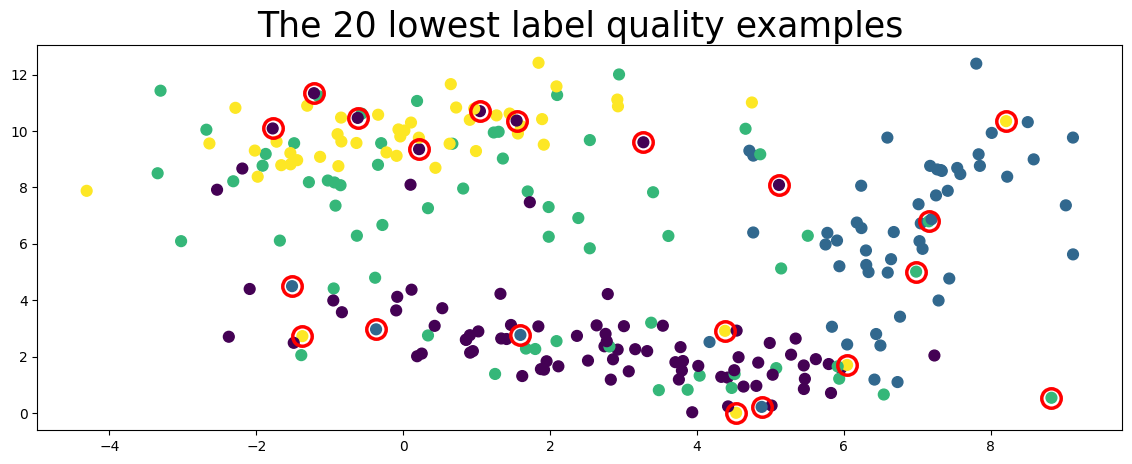

In [184]:
lowest_quality_labels = issues["label_quality"].argsort()[:20]
plot_data(data, circles=lowest_quality_labels, title="The 20 lowest label quality examples")

Above, the top 20 label issues circled in red are found automatically using `cleanlab` (no true labels given).

If you’ve already computed the label issues using `CleanLearning`, you can pass them into `fit()` and it will train much faster (skips label-issue identification step)!

In [185]:
# CleanLearning can train faster if issues are provided at fitting time.
cl.fit(data, labels, label_issues=issues)

CleanLearning(clf=LogisticRegression(random_state=0),
              find_label_issues_kwargs={'confident_joint': array([[68,  0,  8,  8],
       [ 5, 46,  3,  0],
       [15,  3, 31, 14],
       [ 2,  1, 12, 34]]),
                                        'min_examples_per_class': 10},
              seed=0)

## Use `cleanlab` to find dataset-level and class-level issues

- Did you notice that the yellow and seafoam green class above are overlapping?
- How can a model ever know (or learn) what’s ground truth inside the yellow distribution?
- If these two classes were merged, the model can learn more accurately from 3 classes (versus 4).

`cleanlab` automatically finds data-set level issues like this, in one line of code. Check this out!

In [186]:
cleanlab.dataset.find_overlapping_classes(
    labels=labels,
    confident_joint=cl.confident_joint,  # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
    class_names=class_names,
)

,Class Name A,Class Name B,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,seafoam green,yellow,2,3,26,0.104
1,purple,seafoam green,0,2,23,0.092
2,purple,yellow,0,3,10,0.040
3,blue,seafoam green,1,2,6,0.024
4,purple,blue,0,1,5,0.020
5,blue,yellow,1,3,1,0.004


There are two things being happening here:

- Distribution Overlap: The green distribution has huge variance and overlaps with other distributions. `Cleanlab` handles this for you: read the theory behind cleanlab for overlapping classes [here](https://arxiv.org/abs/1705.01936).
- Label Issues: A ton of examples (which actually belong to the purple class) have been mislabeled as “green” in our dataset.

Now, let’s see what happens if we merge classes “seafoam green” and “yellow”

In [187]:
yourFavoriteModel1 = LogisticRegression(random_state=SEED)
yourFavoriteModel1.fit(data, labels)
print(f"[Original classes] Accuracy of yourFavoriteModel: {yourFavoriteModel1.score(test_data, test_labels):.0%}")

merged_labels, merged_test_labels = np.array(labels), np.array(test_labels)

# Merge classes: map all yellow-labeled examples to seafoam green
merged_labels[merged_labels == 3] = 2
merged_test_labels[merged_test_labels == 3] = 2

# Re-run our comparison. Re-run your model on the newly labeled dataset.
yourFavoriteModel2 = LogisticRegression(random_state=SEED)
yourFavoriteModel2.fit(data, merged_labels)
print(f"[Modified classes] Accuracy of yourFavoriteModel: {yourFavoriteModel2.score(test_data, merged_test_labels):.0%}")

# Re-run CleanLearning as well.
yourFavoriteModel3 = LogisticRegression(random_state=SEED)
cl3 = cleanlab.classification.CleanLearning(yourFavoriteModel, seed=SEED)
cl3.fit(data, merged_labels)
print(f"[Modified classes] Accuracy of yourFavoriteModel (+ CleanLearning): {cl3.score(test_data, merged_test_labels):.0%}")

[Original classes] Accuracy of yourFavoriteModel: 83%
[Modified classes] Accuracy of yourFavoriteModel: 94%
[Modified classes] Accuracy of yourFavoriteModel (+ CleanLearning): 96%


While on one hand that’s a huge improvement, it’s important to remember that choosing among three classes is an easier task than choosing among four classes, so it’s not fair to directly compare these numbers. Instead, the big takeaway is… if you get to choose your classes, combining overlapping classes can make the learning task easier for your model!

## Clean your test set too if you’re doing ML with noisy labels!

If your test and training data were randomly split, then be aware that your test labels are likely noisy too! It is thus important to fix label issues in them before we can trust measures like test accuracy.

In [188]:
# Fit your model on noisily labeled train data
yourFavoriteModel = LogisticRegression(random_state=SEED)
yourFavoriteModel.fit(data, labels)

# Get predicted probabilities for test data (these are out-of-sample)
my_test_pred_probs = yourFavoriteModel.predict_proba(test_data)
my_test_preds = my_test_pred_probs.argmax(axis=1)  # predicted labels

# Find label issues in the test data
issues_test = CleanLearning(yourFavoriteModel, seed=SEED).find_label_issues(
    labels=noisy_test_labels, pred_probs=my_test_pred_probs)

issues_test.head()

,is_label_issue,label_quality,given_label,predicted_label
0,False,0.702928,0,0
1,True,0.009424,1,0
2,False,0.788496,0,0
3,True,0.207895,2,0
4,False,0.713635,0,0


In [189]:
# You should inspect issues_test and fix issues to ensure high-quality test data labels.
#=========================================================================================
corrected_test_labels = test_labels  # Here we'll pretend you have done this perfectly :)
#=========================================================================================
# Fit more robust version of model on noisily labeled training data
cl = CleanLearning(yourFavoriteModel, seed=SEED).fit(data, labels)
cl_test_preds = cl.predict(test_data)

print(f" Noisy Test Accuracy (on given test labels) using yourFavoriteModel: {accuracy_score(noisy_test_labels, my_test_preds):.0%}")
print(f" Noisy Test Accuracy (on given test labels) using yourFavoriteModel (+ CleanLearning): {accuracy_score(noisy_test_labels, cl_test_preds):.0%}")
print(f"Actual Test Accuracy (on corrected test labels) using yourFavoriteModel: {accuracy_score(corrected_test_labels, my_test_preds):.0%}")
print(f"Actual Test Accuracy (on corrected test labels) using yourFavoriteModel (+ CleanLearning): {accuracy_score(corrected_test_labels, cl_test_preds):.0%}")

 Noisy Test Accuracy (on given test labels) using yourFavoriteModel: 69%
 Noisy Test Accuracy (on given test labels) using yourFavoriteModel (+ CleanLearning): 71%
Actual Test Accuracy (on corrected test labels) using yourFavoriteModel: 83%
Actual Test Accuracy (on corrected test labels) using yourFavoriteModel (+ CleanLearning): 86%


## One score to rule them all – use cleanlab’s overall dataset health score

This score can be fairly compared across datasets or across versions of a dataset to track overall dataset quality (a.k.a. dataset health) over time.

In [190]:
# One line of code.
health = cleanlab.dataset.health_summary(
    labels, confident_joint=cl.confident_joint
    # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
)

--------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary        |
|   for your dataset with 250 examples and 4 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.      |
--------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



,Class Index,Label Issues,Inverse Label Issues,Label Noise,Inverse Label Noise,Label Quality Score
0,2,32,23,0.507937,0.425926,0.492063
1,3,15,22,0.306122,0.392857,0.693878
2,0,16,22,0.190476,0.244444,0.809524
3,1,8,4,0.148148,0.080000,0.851852



Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



,Class Index A,Class Index B,Num Overlapping Examples,Joint Probability
0,2,3,26,0.104
1,0,2,23,0.092
2,0,3,10,0.040
3,1,2,6,0.024
4,0,1,5,0.020
5,1,3,1,0.004



 * Overall, about 28% (71 of the 250) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.72.

Generated with <3 from Cleanlab.



In [191]:
# One line of code.
health = cleanlab.dataset.overall_label_health_score(
    labels, confident_joint=cl.confident_joint
    # cleanlab uses the confident_joint internally to quantify label noise (see cleanlab.count.compute_confident_joint)
)

 * Overall, about 28% (71 of the 250) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.72.


Because we know the true labels (we created this toy dataset), we can compare with ground truth.

In [192]:
label_acc = sum(labels != true_labels) / len(labels)
print(f"Percentage of label issues guessed by cleanlab {1 - health:.0%}")
print(f"Percentage of (ground truth) label errors): {label_acc:.0%}")

offset = (1 - label_acc) - health
offset

Percentage of label issues guessed by cleanlab 28%
Percentage of (ground truth) label errors): 20%


0.08399999999999996

`cleanlab` seems to be overestimating. Since data points that fall in between two overlapping distributions are often impossible to label and are counted as issues.

For more details, see https://docs.cleanlab.ai/stable/tutorials/indepth_overview.html#

# 🔍 Use `Docta` to find the label issues

Another package that is useful is [Docta](https://github.com/Docta-ai/docta).

# 📘 References

1. https://www.kaggle.com/learn/feature-engineering
2. https://www.kaggle.com/learn/data-cleaning
3. https://madewithml.com/courses/mlops/preprocessing/
4. https://github.com/microsoft/Data-Science-For-Beginners/blob/main/2-Working-With-Data/08-data-preparation/README.md
5. https://scikit-learn.org/stable/modules/preprocessing.html#
6. https://www.books.com.tw/products/0010883417
7. https://docs.cleanlab.ai/stable/tutorials/indepth_overview.html#